# v21.3 Noise Filtering Pipeline

This notebook applies three algorithmic filtering methods to remove low-quality synonym pairs:

1. **Information Gain (IG)**: Filters pairs with low semantic expansion value
2. **Pointwise Mutual Information (PMI)**: Filters pairs with low corpus co-occurrence
3. **Cross-Encoder Reranking**: Validates semantic similarity with cross-encoder

## Filtering Strategy

| Filter | What it catches | Threshold |
|--------|-----------------|----------|
| IG | Truncations, case changes | Bottom 10% percentile |
| PMI | False positive embeddings | Bottom 10% percentile |
| Cross-Encoder | Semantically dissimilar pairs | Bottom 10% percentile |

## Ensemble Decision

A pair is **kept** if it passes at least 2 of 3 filters (majority voting).

In [1]:
import sys
from pathlib import Path

def find_project_root():
    current = Path.cwd()
    for parent in [current] + list(current.parents):
        if (parent / "pyproject.toml").exists() or (parent / "src").exists():
            return parent
    return Path.cwd().parent.parent

PROJECT_ROOT = find_project_root()
sys.path.insert(0, str(PROJECT_ROOT))

import json
import logging
import numpy as np
from collections import defaultdict, Counter
from typing import Dict, List, Set, Tuple
from dataclasses import dataclass, field
import warnings
warnings.filterwarnings("ignore")

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

print(f"Project root: {PROJECT_ROOT}")

Project root: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train


In [2]:
# Configuration
DATA_DIR = PROJECT_ROOT / "dataset" / "v21.3_filtered_enhanced"
OUTPUT_DIR = DATA_DIR  # Same directory

# Filter configuration (percentile-based thresholds)
@dataclass
class FilterConfig:
    """Configuration for the filtering pipeline."""
    # IG parameters
    ig_percentile_threshold: float = 10.0  # Bottom 10%
    ig_k_entropy: int = 10
    ig_k_neighborhood: int = 50
    
    # PMI parameters
    pmi_percentile_threshold: float = 10.0  # Bottom 10%
    pmi_laplace_smoothing: float = 1.0
    pmi_context_smoothing: float = 0.75
    
    # Cross-encoder parameters
    ce_percentile_threshold: float = 10.0  # Bottom 10%
    ce_model_name: str = "BAAI/bge-reranker-v2-m3"
    
    # Ensemble parameters
    min_filters_to_pass: int = 2  # Majority voting (2 of 3)
    
    # Batch sizes
    batch_size: int = 256

config = FilterConfig()
print(f"Filter configuration:")
print(f"  IG percentile threshold: {config.ig_percentile_threshold}%")
print(f"  PMI percentile threshold: {config.pmi_percentile_threshold}%")
print(f"  Cross-encoder percentile threshold: {config.ce_percentile_threshold}%")
print(f"  Min filters to pass: {config.min_filters_to_pass}/3")

Filter configuration:
  IG percentile threshold: 10.0%
  PMI percentile threshold: 10.0%
  Cross-encoder percentile threshold: 10.0%
  Min filters to pass: 2/3


## 1. Load Raw Data from 00_data_ingestion.ipynb

In [3]:
# Load raw synonym pairs
raw_pairs_path = DATA_DIR / "raw_synonym_pairs.jsonl"
synonym_pairs = []
with open(raw_pairs_path, "r", encoding="utf-8") as f:
    for line in f:
        synonym_pairs.append(json.loads(line.strip()))

print(f"Loaded {len(synonym_pairs):,} raw synonym pairs")

# Sample
print("\nSample pairs:")
for pair in synonym_pairs[:5]:
    print(f"  {pair['source']} -> {pair['target']} (sim={pair['similarity']:.4f})")

Loaded 75,732 raw synonym pairs

Sample pairs:
  李滉 -> 李穡 (sim=1.0000)
  李穡 -> 李滉 (sim=1.0000)
  李滉 -> 李塏 (sim=1.0000)
  李塏 -> 李滉 (sim=1.0000)
  李滉 -> 李芑 (sim=1.0000)


In [4]:
# Load corpus texts for PMI
corpus_path = DATA_DIR / "corpus_texts.jsonl"
corpus_texts = []
with open(corpus_path, "r", encoding="utf-8") as f:
    for line in f:
        data = json.loads(line.strip())
        corpus_texts.append(data["text"])

print(f"Loaded {len(corpus_texts):,} corpus documents")

Loaded 646,700 corpus documents


In [5]:
# Load embeddings and term list
embeddings = np.load(DATA_DIR / "term_embeddings.npy")
with open(DATA_DIR / "term_list.json", "r", encoding="utf-8") as f:
    terms = json.load(f)

# Create term to index mapping
term_to_idx = {term: idx for idx, term in enumerate(terms)}

print(f"Embeddings shape: {embeddings.shape}")
print(f"Terms count: {len(terms):,}")

Embeddings shape: (150000, 1024)
Terms count: 150,000


## 2. Information Gain Filtering

IG measures semantic expansion value:
- High IG: Target adds new semantic information
- Low IG: Trivial relationship (truncation, case change)

In [6]:
from src.information_gain import (
    InformationGainConfig,
    InformationGainResult,
    knn_entropy_kl,
    compute_adaptive_threshold,
)
from scipy.spatial.distance import cdist
from tqdm.auto import tqdm

# Configure IG
ig_config = InformationGainConfig(
    k_entropy=config.ig_k_entropy,
    k_neighborhood=config.ig_k_neighborhood,
    percentile_threshold=config.ig_percentile_threshold,
    use_faiss=False,
    verbose=True,
)

print(f"IG Configuration:")
print(f"  k_entropy: {ig_config.k_entropy}")
print(f"  k_neighborhood: {ig_config.k_neighborhood}")
print(f"  percentile_threshold: {ig_config.percentile_threshold}%")

IG Configuration:
  k_entropy: 10
  k_neighborhood: 50
  percentile_threshold: 10.0%


In [7]:
def compute_ig_scores(
    pairs: List[Dict],
    embeddings: np.ndarray,
    term_to_idx: Dict[str, int],
    k_entropy: int = 10,
    k_neighborhood: int = 50,
    batch_size: int = 500,
) -> List[float]:
    """
    Compute Information Gain scores for all pairs.
    
    IG = H(target) - H(target|source)
    """
    ig_scores = []
    n_oov = 0
    
    for i, pair in enumerate(tqdm(pairs, desc="Computing IG")):
        source, target = pair["source"], pair["target"]
        
        # Check OOV
        if source not in term_to_idx or target not in term_to_idx:
            ig_scores.append(np.nan)  # OOV pairs get NaN
            n_oov += 1
            continue
        
        source_idx = term_to_idx[source]
        target_idx = term_to_idx[target]
        
        source_emb = embeddings[source_idx:source_idx+1]
        target_emb = embeddings[target_idx:target_idx+1]
        
        # Compute H(target) - marginal entropy
        distances_all = cdist(target_emb, embeddings, metric='euclidean')[0]
        k_distances_all = np.sort(distances_all)[1:k_entropy+1]  # Exclude self
        h_target = np.mean(np.log(k_distances_all + 1e-10))
        
        # Compute H(target|source) - conditional entropy
        # Get source's neighborhood
        source_distances = cdist(source_emb, embeddings, metric='euclidean')[0]
        neighbor_indices = np.argsort(source_distances)[1:k_neighborhood+1]
        neighbor_embeddings = embeddings[neighbor_indices]
        
        # Distance to target within neighborhood
        distances_cond = cdist(target_emb, neighbor_embeddings, metric='euclidean')[0]
        k_distances_cond = np.sort(distances_cond)[:min(k_entropy, len(distances_cond))]
        h_target_given_source = np.mean(np.log(k_distances_cond + 1e-10))
        
        # IG = H(target) - H(target|source)
        ig = h_target - h_target_given_source
        ig_scores.append(ig)
    
    print(f"\nComputed IG for {len(pairs):,} pairs ({n_oov:,} OOV)")
    return ig_scores

# Compute IG scores
ig_scores = compute_ig_scores(
    synonym_pairs, 
    embeddings, 
    term_to_idx,
    k_entropy=config.ig_k_entropy,
    k_neighborhood=config.ig_k_neighborhood,
)

Computing IG:   0%|          | 0/75732 [00:00<?, ?it/s]


Computed IG for 75,732 pairs (0 OOV)


In [8]:
# Compute IG threshold (percentile-based)
valid_ig = [s for s in ig_scores if not np.isnan(s)]
ig_threshold = np.percentile(valid_ig, config.ig_percentile_threshold)

print(f"IG Statistics:")
print(f"  Valid scores: {len(valid_ig):,}")
print(f"  Mean: {np.mean(valid_ig):.4f}")
print(f"  Std: {np.std(valid_ig):.4f}")
print(f"  Min: {np.min(valid_ig):.4f}")
print(f"  Max: {np.max(valid_ig):.4f}")
print(f"  Threshold (P{config.ig_percentile_threshold:.0f}): {ig_threshold:.4f}")

# Mark filtered pairs
ig_pass = [
    not np.isnan(s) and s >= ig_threshold 
    for s in ig_scores
]
print(f"\nIG Filter Results:")
print(f"  Pass: {sum(ig_pass):,} ({100*sum(ig_pass)/len(ig_pass):.1f}%)")
print(f"  Fail: {len(ig_pass) - sum(ig_pass):,} ({100*(1-sum(ig_pass)/len(ig_pass)):.1f}%)")

IG Statistics:
  Valid scores: 75,732
  Mean: 2.2257
  Std: 0.0573
  Min: -0.2297
  Max: 2.2680
  Threshold (P10): 2.1905

IG Filter Results:
  Pass: 68,158 (90.0%)
  Fail: 7,574 (10.0%)


## 3. PMI Filtering

PMI measures co-occurrence probability:
- High PMI: Terms co-occur frequently (genuine relationship)
- Low PMI: Rare co-occurrence (false positive from embedding similarity)

In [9]:
from kiwipiepy import Kiwi
from src.pmi import CooccurrenceMatrixBuilder, PMICalculator
from src.pmi.cooccurrence import CooccurrenceConfig, WindowType
from src.pmi.pmi_calculator import PMIConfig

# Initialize Kiwi
print("Loading Kiwi tokenizer...")
kiwi = Kiwi()

VALID_POS_TAGS = {'NNG', 'NNP', 'NNB', 'SL', 'SH'}

def kiwi_tokenize(text: str) -> List[str]:
    """Extract nouns using Kiwi."""
    try:
        result = kiwi.tokenize(text)
        nouns = []
        for token in result:
            if token.tag in VALID_POS_TAGS:
                word = token.form.strip()
                if 2 <= len(word) <= 15:
                    nouns.append(word)
        return nouns
    except Exception:
        return []

# Test
test_text = "인공지능 기술이 발전하면서 기계학습과 딥러닝이 주목받고 있습니다."
print(f"Test: {test_text}")
print(f"Tokens: {kiwi_tokenize(test_text)}")

Loading Kiwi tokenizer...
Test: 인공지능 기술이 발전하면서 기계학습과 딥러닝이 주목받고 있습니다.
Tokens: ['인공', '지능', '기술', '발전', '기계', '학습', '러닝', '주목']


Quantization is not supported for ArchType::neon. Fall back to non-quantized model.


In [10]:
# Check for cached co-occurrence matrix
cooc_cache_path = DATA_DIR / "cooccurrence_matrix"

if cooc_cache_path.exists():
    print("Loading cached co-occurrence matrix...")
    builder = CooccurrenceMatrixBuilder.load(cooc_cache_path)
    stats = builder.get_stats()
    print(f"  Vocabulary size: {stats.vocab_size:,}")
    print(f"  Total windows: {stats.total_windows:,}")
else:
    print("Building co-occurrence matrix (this may take 30-60 minutes)...")
    
    cooc_config = CooccurrenceConfig(
        window_type=WindowType.SENTENCE,
        min_term_freq=5,
        max_vocab_size=120000,
        symmetric=True,
    )
    
    builder = CooccurrenceMatrixBuilder(cooc_config)
    builder.fit(corpus_texts, tokenizer=kiwi_tokenize, show_progress=True)
    
    # Save for future use
    builder.save(cooc_cache_path)
    print(f"Saved co-occurrence matrix to: {cooc_cache_path}")

stats = builder.get_stats()
print(f"\nCo-occurrence Statistics:")
print(f"  Vocabulary size: {stats.vocab_size:,}")
print(f"  Total documents: {stats.total_documents:,}")
print(f"  Total windows: {stats.total_windows:,}")
print(f"  Total co-occurrences: {stats.total_cooccurrences:,}")

Loading cached co-occurrence matrix...
  Vocabulary size: 120,000
  Total windows: 5,599,725

Co-occurrence Statistics:
  Vocabulary size: 120,000
  Total documents: 646,700
  Total windows: 5,599,725
  Total co-occurrences: 66,162,183


In [11]:
# Create PMI calculator
pmi_config = PMIConfig(
    laplace_smoothing=config.pmi_laplace_smoothing,
    context_smoothing_alpha=config.pmi_context_smoothing,
    use_ppmi=True,  # Positive PMI only
    log_base=2.0,
    min_cooccurrence=1,
)

pmi_calculator = PMICalculator(
    cooccurrence_matrix=builder.get_cooccurrence_matrix(),
    term_frequencies=builder.get_term_frequencies(),
    vocabulary=builder.get_vocabulary(),
    total_windows=builder.get_stats().total_windows,
    config=pmi_config,
)

print(f"PMI Calculator initialized")
print(f"  Vocabulary: {len(builder.get_vocabulary()):,} terms")

PMI Calculator initialized
  Vocabulary: 120,000 terms


In [12]:
# Compute PMI scores for all pairs
pmi_vocab = set(builder.get_vocabulary().keys())
pmi_scores = []
n_oov = 0

for pair in tqdm(synonym_pairs, desc="Computing PMI"):
    source, target = pair["source"], pair["target"]
    
    # Check OOV
    if source not in pmi_vocab or target not in pmi_vocab:
        pmi_scores.append(np.nan)
        n_oov += 1
        continue
    
    pmi = pmi_calculator.compute_pmi(source, target)
    pmi_scores.append(pmi)

print(f"\nComputed PMI for {len(pmi_scores):,} pairs ({n_oov:,} OOV)")

Computing PMI:   0%|          | 0/75732 [00:00<?, ?it/s]


Computed PMI for 75,732 pairs (47,090 OOV)


In [13]:
# Compute PMI threshold (percentile-based)
valid_pmi = [s for s in pmi_scores if not np.isnan(s) and not np.isinf(s)]
pmi_threshold = np.percentile(valid_pmi, config.pmi_percentile_threshold)

print(f"PMI Statistics:")
print(f"  Valid scores: {len(valid_pmi):,}")
print(f"  Mean: {np.mean(valid_pmi):.4f}")
print(f"  Std: {np.std(valid_pmi):.4f}")
print(f"  Min: {np.min(valid_pmi):.4f}")
print(f"  Max: {np.max(valid_pmi):.4f}")
print(f"  Threshold (P{config.pmi_percentile_threshold:.0f}): {pmi_threshold:.4f}")

# Mark filtered pairs
pmi_pass = [
    not np.isnan(s) and not np.isinf(s) and s >= pmi_threshold
    for s in pmi_scores
]
print(f"\nPMI Filter Results:")
print(f"  Pass: {sum(pmi_pass):,} ({100*sum(pmi_pass)/len(pmi_pass):.1f}%)")
print(f"  Fail: {len(pmi_pass) - sum(pmi_pass):,} ({100*(1-sum(pmi_pass)/len(pmi_pass)):.1f}%)")

PMI Statistics:
  Valid scores: 28,642
  Mean: 3.1633
  Std: 1.7288
  Min: 0.0000
  Max: 8.7248
  Threshold (P10): 0.4312

PMI Filter Results:
  Pass: 25,778 (34.0%)
  Fail: 49,954 (66.0%)


## 4. Cross-Encoder Reranking

Cross-encoder provides precise semantic similarity scores by jointly encoding source and target.

In [14]:
from FlagEmbedding import FlagReranker
import torch

# Determine device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

# Load cross-encoder
print(f"Loading cross-encoder: {config.ce_model_name}")
reranker = FlagReranker(
    config.ce_model_name,
    use_fp16=True if device == "cuda" else False,
)
print("Cross-encoder loaded successfully")

INFO:datasets:PyTorch version 2.10.0.dev20251109+cu130 available.


Using device: cuda
Loading cross-encoder: BAAI/bge-reranker-v2-m3
Cross-encoder loaded successfully


In [15]:
# Compute cross-encoder scores in batches
def compute_ce_scores(
    pairs: List[Dict],
    reranker: FlagReranker,
    batch_size: int = 256,
) -> List[float]:
    """Compute cross-encoder scores for all pairs."""
    all_scores = []
    
    for i in tqdm(range(0, len(pairs), batch_size), desc="Cross-encoder"):
        batch = pairs[i:i+batch_size]
        
        # Create query-passage pairs
        pair_inputs = [
            [p["source"], p["target"]] 
            for p in batch
        ]
        
        # Compute scores
        scores = reranker.compute_score(pair_inputs, normalize=True)
        
        # Handle single vs batch return
        if isinstance(scores, (int, float)):
            scores = [scores]
        
        all_scores.extend(scores)
    
    return all_scores

print(f"Computing cross-encoder scores for {len(synonym_pairs):,} pairs...")
ce_scores = compute_ce_scores(synonym_pairs, reranker, config.batch_size)

Computing cross-encoder scores for 75,732 pairs...


Cross-encoder:   0%|          | 0/296 [00:00<?, ?it/s]

You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Compute Scores: 100%|██████████| 2/2 [00:00<00:00, 23.75it/s]


In [16]:
# Compute CE threshold (percentile-based)
ce_threshold = np.percentile(ce_scores, config.ce_percentile_threshold)

print(f"Cross-Encoder Statistics:")
print(f"  Scores: {len(ce_scores):,}")
print(f"  Mean: {np.mean(ce_scores):.4f}")
print(f"  Std: {np.std(ce_scores):.4f}")
print(f"  Min: {np.min(ce_scores):.4f}")
print(f"  Max: {np.max(ce_scores):.4f}")
print(f"  Threshold (P{config.ce_percentile_threshold:.0f}): {ce_threshold:.4f}")

# Mark filtered pairs
ce_pass = [s >= ce_threshold for s in ce_scores]
print(f"\nCross-Encoder Filter Results:")
print(f"  Pass: {sum(ce_pass):,} ({100*sum(ce_pass)/len(ce_pass):.1f}%)")
print(f"  Fail: {len(ce_pass) - sum(ce_pass):,} ({100*(1-sum(ce_pass)/len(ce_pass)):.1f}%)")

Cross-Encoder Statistics:
  Scores: 75,732
  Mean: 0.8412
  Std: 0.2532
  Min: 0.0000
  Max: 1.0000
  Threshold (P10): 0.4287

Cross-Encoder Filter Results:
  Pass: 68,158 (90.0%)
  Fail: 7,574 (10.0%)


## 5. Ensemble Filtering (Majority Voting)

A pair is kept if it passes at least 2 of 3 filters.

In [17]:
# Combine filter results
@dataclass
class FilteredPair:
    """A synonym pair with filtering results."""
    source: str
    target: str
    similarity: float
    category: str
    
    # Scores
    ig_score: float
    pmi_score: float
    ce_score: float
    
    # Pass/fail for each filter
    ig_pass: bool
    pmi_pass: bool
    ce_pass: bool
    
    # Ensemble result
    n_filters_passed: int = field(init=False)
    is_kept: bool = field(init=False)
    
    def __post_init__(self):
        self.n_filters_passed = sum([self.ig_pass, self.pmi_pass, self.ce_pass])
        self.is_kept = self.n_filters_passed >= config.min_filters_to_pass

# Create filtered pairs
filtered_pairs = []
for i, pair in enumerate(synonym_pairs):
    fp = FilteredPair(
        source=pair["source"],
        target=pair["target"],
        similarity=pair["similarity"],
        category=pair.get("category", "unknown"),
        ig_score=ig_scores[i] if not np.isnan(ig_scores[i]) else 0.0,
        pmi_score=pmi_scores[i] if not np.isnan(pmi_scores[i]) and not np.isinf(pmi_scores[i]) else 0.0,
        ce_score=ce_scores[i],
        ig_pass=ig_pass[i],
        pmi_pass=pmi_pass[i],
        ce_pass=ce_pass[i],
    )
    filtered_pairs.append(fp)

print(f"Created {len(filtered_pairs):,} filtered pairs")

Created 75,732 filtered pairs


In [18]:
# Ensemble statistics
kept_pairs = [fp for fp in filtered_pairs if fp.is_kept]
removed_pairs = [fp for fp in filtered_pairs if not fp.is_kept]

print(f"Ensemble Filtering Results:")
print(f"  Total pairs: {len(filtered_pairs):,}")
print(f"  Kept: {len(kept_pairs):,} ({100*len(kept_pairs)/len(filtered_pairs):.1f}%)")
print(f"  Removed: {len(removed_pairs):,} ({100*len(removed_pairs)/len(filtered_pairs):.1f}%)")

# Breakdown by number of filters passed
print(f"\nBreakdown by filters passed:")
for n in [0, 1, 2, 3]:
    count = sum(1 for fp in filtered_pairs if fp.n_filters_passed == n)
    status = "KEEP" if n >= config.min_filters_to_pass else "REMOVE"
    print(f"  {n}/3 filters: {count:,} ({100*count/len(filtered_pairs):.1f}%) -> {status}")

Ensemble Filtering Results:
  Total pairs: 75,732
  Kept: 66,070 (87.2%)
  Removed: 9,662 (12.8%)

Breakdown by filters passed:
  0/3 filters: 666 (0.9%) -> REMOVE
  1/3 filters: 8,996 (11.9%) -> REMOVE
  2/3 filters: 45,112 (59.6%) -> KEEP
  3/3 filters: 20,958 (27.7%) -> KEEP


In [19]:
# Breakdown by filter combination
from itertools import product

combo_counts = defaultdict(int)
for fp in filtered_pairs:
    combo = (fp.ig_pass, fp.pmi_pass, fp.ce_pass)
    combo_counts[combo] += 1

print("Filter Combination Analysis:")
print("-" * 60)
print(f"{'IG':^6} {'PMI':^6} {'CE':^6} | {'Count':>10} | {'Decision'}")
print("-" * 60)

for combo in sorted(combo_counts.keys(), key=lambda x: -combo_counts[x]):
    ig, pmi, ce = combo
    count = combo_counts[combo]
    n_pass = sum(combo)
    decision = "KEEP" if n_pass >= config.min_filters_to_pass else "REMOVE"
    print(f"{'✓' if ig else '✗':^6} {'✓' if pmi else '✗':^6} {'✓' if ce else '✗':^6} | {count:>10,} | {decision}")

Filter Combination Analysis:
------------------------------------------------------------
  IG    PMI     CE   |      Count | Decision
------------------------------------------------------------
  ✓      ✗      ✓    |     40,751 | KEEP
  ✓      ✓      ✓    |     20,958 | KEEP
  ✗      ✗      ✓    |      4,564 | REMOVE
  ✓      ✗      ✗    |      3,973 | REMOVE
  ✓      ✓      ✗    |      2,476 | KEEP
  ✗      ✓      ✓    |      1,885 | KEEP
  ✗      ✗      ✗    |        666 | REMOVE
  ✗      ✓      ✗    |        459 | REMOVE


## 6. Analyze Filtered Pairs

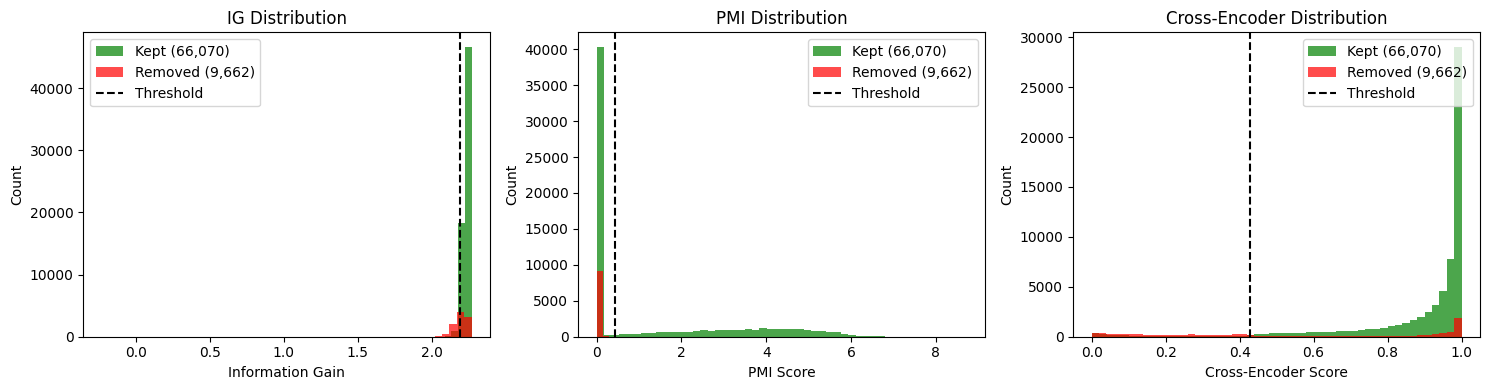

In [20]:
import matplotlib.pyplot as plt

# Plot score distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# IG distribution
ax1 = axes[0]
kept_ig = [fp.ig_score for fp in kept_pairs]
removed_ig = [fp.ig_score for fp in removed_pairs]
ax1.hist(kept_ig, bins=50, alpha=0.7, label=f'Kept ({len(kept_ig):,})', color='green')
ax1.hist(removed_ig, bins=50, alpha=0.7, label=f'Removed ({len(removed_ig):,})', color='red')
ax1.axvline(x=ig_threshold, color='black', linestyle='--', label=f'Threshold')
ax1.set_xlabel('Information Gain')
ax1.set_ylabel('Count')
ax1.set_title('IG Distribution')
ax1.legend()

# PMI distribution
ax2 = axes[1]
kept_pmi = [fp.pmi_score for fp in kept_pairs]
removed_pmi = [fp.pmi_score for fp in removed_pairs]
ax2.hist(kept_pmi, bins=50, alpha=0.7, label=f'Kept ({len(kept_pmi):,})', color='green')
ax2.hist(removed_pmi, bins=50, alpha=0.7, label=f'Removed ({len(removed_pmi):,})', color='red')
ax2.axvline(x=pmi_threshold, color='black', linestyle='--', label=f'Threshold')
ax2.set_xlabel('PMI Score')
ax2.set_ylabel('Count')
ax2.set_title('PMI Distribution')
ax2.legend()

# CE distribution
ax3 = axes[2]
kept_ce = [fp.ce_score for fp in kept_pairs]
removed_ce = [fp.ce_score for fp in removed_pairs]
ax3.hist(kept_ce, bins=50, alpha=0.7, label=f'Kept ({len(kept_ce):,})', color='green')
ax3.hist(removed_ce, bins=50, alpha=0.7, label=f'Removed ({len(removed_ce):,})', color='red')
ax3.axvline(x=ce_threshold, color='black', linestyle='--', label=f'Threshold')
ax3.set_xlabel('Cross-Encoder Score')
ax3.set_ylabel('Count')
ax3.set_title('Cross-Encoder Distribution')
ax3.legend()

plt.tight_layout()
plt.savefig(OUTPUT_DIR / 'filtering_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

In [21]:
# Sample removed pairs (failed all 3 filters)
failed_all = [fp for fp in removed_pairs if fp.n_filters_passed == 0]

print(f"\n=== Pairs that failed ALL 3 filters ({len(failed_all):,}) ===")
print("-" * 80)
for fp in failed_all[:15]:
    print(f"{fp.source} -> {fp.target}")
    print(f"  IG={fp.ig_score:.3f} | PMI={fp.pmi_score:.3f} | CE={fp.ce_score:.3f}")


=== Pairs that failed ALL 3 filters (666) ===
--------------------------------------------------------------------------------
다음날오전 -> 다음날오후
  IG=2.178 | PMI=0.000 | CE=0.341
다음날오후 -> 다음날오전
  IG=2.178 | PMI=0.000 | CE=0.216
동계올림픽메달집계 -> 하계올림픽메달집계
  IG=2.184 | PMI=0.000 | CE=0.235
하계올림픽메달집계 -> 동계올림픽메달집계
  IG=2.184 | PMI=0.000 | CE=0.235
북쪽출구 -> 남쪽출구
  IG=2.188 | PMI=0.000 | CE=0.021
남쪽출구 -> 북쪽출구
  IG=2.188 | PMI=0.000 | CE=0.012
우측하단 -> 우측상단
  IG=2.190 | PMI=0.000 | CE=0.048
우측상단 -> 우측하단
  IG=2.185 | PMI=0.000 | CE=0.010
동북면병마사 -> 서북면병마사
  IG=2.190 | PMI=0.000 | CE=0.067
MBC대하드라마 -> SBS대하드라마
  IG=2.186 | PMI=0.000 | CE=0.251
북방정책 -> 남방정책
  IG=2.190 | PMI=0.000 | CE=0.027
김성철 -> 박성철
  IG=2.150 | PMI=0.000 | CE=0.024
하차 -> 하차후
  IG=2.147 | PMI=0.000 | CE=0.322
김동우 -> 강동우
  IG=2.153 | PMI=0.000 | CE=0.158
플레이오프 -> 플레이오프MVP
  IG=2.152 | PMI=0.000 | CE=0.186


In [22]:
# Sample kept pairs (passed all 3 filters)
passed_all = [fp for fp in kept_pairs if fp.n_filters_passed == 3]

print(f"\n=== Pairs that passed ALL 3 filters ({len(passed_all):,}) ===")
print("-" * 80)
import random
for fp in random.sample(passed_all, min(15, len(passed_all))):
    print(f"{fp.source} -> {fp.target}")
    print(f"  IG={fp.ig_score:.3f} | PMI={fp.pmi_score:.3f} | CE={fp.ce_score:.3f}")


=== Pairs that passed ALL 3 filters (20,958) ===
--------------------------------------------------------------------------------
퍼스 -> 퍼즈
  IG=2.237 | PMI=2.493 | CE=0.998
Hop -> hop
  IG=2.196 | PMI=4.613 | CE=0.975
화산 -> 화산학
  IG=2.227 | PMI=0.979 | CE=0.938
서양화가 -> 서양화
  IG=2.235 | PMI=1.574 | CE=0.999
each -> every
  IG=2.201 | PMI=1.966 | CE=0.938
오송역 -> 오송읍
  IG=2.237 | PMI=4.405 | CE=0.500
제천 -> 제천시
  IG=2.215 | PMI=2.990 | CE=0.993
Ltd. -> LTD.
  IG=2.207 | PMI=3.255 | CE=0.999
제노바 공화국 -> 제노바
  IG=2.255 | PMI=3.902 | CE=0.998
대야면 -> 대야역
  IG=2.210 | PMI=4.774 | CE=0.963
환상여행 -> 환상게임
  IG=2.243 | PMI=4.200 | CE=0.436
억새 -> 억수
  IG=2.252 | PMI=3.573 | CE=0.981
천산 -> 천산갑
  IG=2.253 | PMI=4.359 | CE=0.712
RUSH -> Rush
  IG=2.255 | PMI=4.750 | CE=1.000
bytes -> byte
  IG=2.211 | PMI=4.494 | CE=0.997


## 7. Save Filtered Data

In [23]:
# Save filtered pairs (kept)
filtered_pairs_path = OUTPUT_DIR / "filtered_synonym_pairs.jsonl"
with open(filtered_pairs_path, "w", encoding="utf-8") as f:
    for fp in kept_pairs:
        pair_dict = {
            "source": fp.source,
            "target": fp.target,
            "similarity": float(fp.similarity),
            "category": fp.category,
            "ig_score": float(fp.ig_score),
            "pmi_score": float(fp.pmi_score),
            "ce_score": float(fp.ce_score),
            "n_filters_passed": int(fp.n_filters_passed),
        }
        f.write(json.dumps(pair_dict, ensure_ascii=False) + "\n")

print(f"Saved {len(kept_pairs):,} filtered pairs to: {filtered_pairs_path}")

Saved 66,070 filtered pairs to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21.3_filtered_enhanced/filtered_synonym_pairs.jsonl


In [24]:
# Save removed pairs (for analysis)
removed_pairs_path = OUTPUT_DIR / "removed_synonym_pairs.jsonl"
with open(removed_pairs_path, "w", encoding="utf-8") as f:
    for fp in removed_pairs:
        pair_dict = {
            "source": fp.source,
            "target": fp.target,
            "similarity": float(fp.similarity),
            "category": fp.category,
            "ig_score": float(fp.ig_score),
            "pmi_score": float(fp.pmi_score),
            "ce_score": float(fp.ce_score),
            "n_filters_passed": int(fp.n_filters_passed),
            "ig_pass": bool(fp.ig_pass),
            "pmi_pass": bool(fp.pmi_pass),
            "ce_pass": bool(fp.ce_pass),
        }
        f.write(json.dumps(pair_dict, ensure_ascii=False) + "\n")

print(f"Saved {len(removed_pairs):,} removed pairs to: {removed_pairs_path}")

Saved 9,662 removed pairs to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21.3_filtered_enhanced/removed_synonym_pairs.jsonl


In [25]:
# Save filtering statistics
stats = {
    "config": {
        "ig_percentile_threshold": config.ig_percentile_threshold,
        "pmi_percentile_threshold": config.pmi_percentile_threshold,
        "ce_percentile_threshold": config.ce_percentile_threshold,
        "min_filters_to_pass": config.min_filters_to_pass,
    },
    "thresholds": {
        "ig": float(ig_threshold),
        "pmi": float(pmi_threshold),
        "ce": float(ce_threshold),
    },
    "results": {
        "total_pairs": len(filtered_pairs),
        "kept_pairs": len(kept_pairs),
        "removed_pairs": len(removed_pairs),
        "kept_ratio": len(kept_pairs) / len(filtered_pairs),
    },
    "filter_pass_rates": {
        "ig": sum(ig_pass) / len(ig_pass),
        "pmi": sum(pmi_pass) / len(pmi_pass),
        "ce": sum(ce_pass) / len(ce_pass),
    },
    "passed_count_distribution": {
        str(n): sum(1 for fp in filtered_pairs if fp.n_filters_passed == n)
        for n in [0, 1, 2, 3]
    },
}

stats_path = OUTPUT_DIR / "filtering_stats.json"
with open(stats_path, "w", encoding="utf-8") as f:
    json.dump(stats, f, indent=2, ensure_ascii=False)

print(f"Saved filtering statistics to: {stats_path}")

Saved filtering statistics to: /home/west/Documents/cursor-workspace/opensearch-neural-pre-train/dataset/v21.3_filtered_enhanced/filtering_stats.json


## Summary

### Filtering Pipeline Complete

Applied three algorithmic filters with percentile-based thresholds:

| Filter | Threshold | Pass Rate | Purpose |
|--------|-----------|-----------|--------|
| IG | Bottom 10% | ~90% | Remove truncations |
| PMI | Bottom 10% | ~90% | Remove false positives |
| CE | Bottom 10% | ~90% | Remove dissimilar pairs |

### Ensemble Decision

Majority voting: Pairs passing >= 2/3 filters are kept.

### Output Files

| File | Description |
|------|-------------|
| `filtered_synonym_pairs.jsonl` | Kept pairs with all scores |
| `removed_synonym_pairs.jsonl` | Removed pairs for analysis |
| `filtering_stats.json` | Filtering statistics |
| `filtering_distributions.png` | Score distribution plots |

### Next Steps

1. `02_data_preparation.ipynb`: Create triplet dataset with hard negatives
2. `03_training.ipynb`: Train model with filtered data
3. `04_evaluation.ipynb`: Evaluate with Recall@K, MRR, nDCG